<a href="https://colab.research.google.com/github/mominsiddiqui/Fashion-MNIST/blob/main/FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F 
from torch.utils.data import DataLoader, random_split
import torchvision
from tqdm import tqdm
from torchvision import datasets, models, transforms

In [2]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
batchsize = 64
lr = 0.001
epochs = 30

In [4]:
transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize((0.485), (0.229))
])


dataset = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = transform
)

trainset, validset = random_split(dataset, [55000, 5000])

testset = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = transform
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=batchsize, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
image, label = next(iter(trainloader))
image.shape, label.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [6]:
def trainOneEpoch(model, trainloader, optimizer, criterion):
  train_loss = 0
  train_acc = 0
  total = 0

  model.train()
  for image, label in tqdm(trainloader):
    image, label = image.to(device), label.to(device)
    
    output = model(image)
    loss = criterion(output, label)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, pred = torch.max(output, dim=1)
    train_acc += torch.sum(pred == label).item()
    total += label.size(0)
  

  train_loss = round(float(train_loss/total), 5)
  train_acc  = round(float(train_acc/total), 5)
  
  return train_loss, train_acc

In [7]:
def validEpoch(model, validloader, criterion, scheduler):
  valid_loss = 0
  valid_acc = 0
  total = 0

  with torch.no_grad():
    model.eval()
    for image, label in validloader:
      image, label = image.to(device), label.to(device)
      
      output = model(image)
      loss = criterion(output, label)
      
      valid_loss += loss.item()
      _, pred = torch.max(output, dim=1)
      valid_acc += torch.sum(pred == label).item()
      total += label.size(0)

  scheduler.step(valid_loss)

  valid_loss = round(float(valid_loss/total), 4)
  valid_acc = round(float(valid_acc/total), 4)

  return valid_loss, valid_acc

In [8]:
def trainModel(model, trainloader, validloader, optimizer, criterion, scheduler, epochs):
  train_loss_list = []
  train_acc_list = []
  valid_loss_list = []
  valid_acc_list = []
  max_val_acc = 0

  print("Training started for model\n")
  for epoch in range(epochs):
    print(f"Epoch  ({epoch+1}/{epochs})")
    train_loss, train_acc = trainOneEpoch(model, trainloader, optimizer, criterion)
    print(f"Training Loss: {train_loss}, Training Accuracy: {train_acc}")
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    valid_loss, valid_acc = validEpoch(model, validloader, criterion, scheduler)
    print(f"Validation Loss: {valid_loss}, Validation Accuracy: {valid_acc}")
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)

    if max_val_acc <= valid_acc:
      max_val_acc = valid_acc
      print("Saving Best Model")
      torch.save(model.state_dict(), "bestModel.pt")
    print("-----------------------------\n")
  
  return model, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list

In [12]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(1, 32, 3, padding="same"),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32, 64, 3, padding="same"),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2,2)
    )
    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(64*7*7, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 10)
    )
  
  def forward(self, x):
    output = self.features(x)
    output = output.view(output.size(0), 64*7*7)
    output = self.classifier(output)
    return output

In [13]:
model = Model()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

In [14]:
model, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = trainModel(model, trainloader, validloader, optimizer, criterion, scheduler, epochs)

Training started for model

Epoch  (1/30)


100%|██████████| 860/860 [00:09<00:00, 86.42it/s]


Training Loss: 0.00724, Training Accuracy: 0.83144
Validation Loss: 0.0049, Validation Accuracy: 0.887
Saving Best Model
-----------------------------

Epoch  (2/30)


100%|██████████| 860/860 [00:09<00:00, 86.68it/s]


Training Loss: 0.00494, Training Accuracy: 0.88324
Validation Loss: 0.0042, Validation Accuracy: 0.9028
Saving Best Model
-----------------------------

Epoch  (3/30)


100%|██████████| 860/860 [00:10<00:00, 85.87it/s]


Training Loss: 0.0043, Training Accuracy: 0.8984
Validation Loss: 0.0039, Validation Accuracy: 0.9098
Saving Best Model
-----------------------------

Epoch  (4/30)


100%|██████████| 860/860 [00:09<00:00, 86.56it/s]


Training Loss: 0.00388, Training Accuracy: 0.90773
Validation Loss: 0.0037, Validation Accuracy: 0.9148
Saving Best Model
-----------------------------

Epoch  (5/30)


100%|██████████| 860/860 [00:09<00:00, 86.94it/s]


Training Loss: 0.00357, Training Accuracy: 0.91482
Validation Loss: 0.0034, Validation Accuracy: 0.9168
Saving Best Model
-----------------------------

Epoch  (6/30)


100%|██████████| 860/860 [00:09<00:00, 87.67it/s]


Training Loss: 0.00333, Training Accuracy: 0.92231
Validation Loss: 0.0035, Validation Accuracy: 0.9144
-----------------------------

Epoch  (7/30)


100%|██████████| 860/860 [00:09<00:00, 86.95it/s]


Training Loss: 0.00308, Training Accuracy: 0.9266
Validation Loss: 0.0033, Validation Accuracy: 0.9246
Saving Best Model
-----------------------------

Epoch  (8/30)


100%|██████████| 860/860 [00:09<00:00, 86.40it/s]


Training Loss: 0.00292, Training Accuracy: 0.92971
Validation Loss: 0.0031, Validation Accuracy: 0.9252
Saving Best Model
-----------------------------

Epoch  (9/30)


100%|██████████| 860/860 [00:09<00:00, 87.75it/s]


Training Loss: 0.0027, Training Accuracy: 0.93445
Validation Loss: 0.0031, Validation Accuracy: 0.9272
Saving Best Model
-----------------------------

Epoch  (10/30)


100%|██████████| 860/860 [00:10<00:00, 85.73it/s]


Training Loss: 0.00261, Training Accuracy: 0.93755
Validation Loss: 0.0031, Validation Accuracy: 0.928
Saving Best Model
-----------------------------

Epoch  (11/30)


100%|██████████| 860/860 [00:10<00:00, 85.22it/s]


Training Loss: 0.00251, Training Accuracy: 0.93938
Validation Loss: 0.0031, Validation Accuracy: 0.9288
Saving Best Model
-----------------------------

Epoch  (12/30)


100%|██████████| 860/860 [00:09<00:00, 87.36it/s]


Training Loss: 0.00237, Training Accuracy: 0.9424
Validation Loss: 0.0031, Validation Accuracy: 0.9296
Saving Best Model
-----------------------------

Epoch  (13/30)


100%|██████████| 860/860 [00:09<00:00, 87.10it/s]


Training Loss: 0.00228, Training Accuracy: 0.94431
Validation Loss: 0.0033, Validation Accuracy: 0.9264
-----------------------------

Epoch  (14/30)


100%|██████████| 860/860 [00:10<00:00, 85.21it/s]


Training Loss: 0.00218, Training Accuracy: 0.94667
Validation Loss: 0.0031, Validation Accuracy: 0.933
Saving Best Model
-----------------------------

Epoch  (15/30)


100%|██████████| 860/860 [00:09<00:00, 86.42it/s]


Training Loss: 0.00208, Training Accuracy: 0.94842
Validation Loss: 0.0031, Validation Accuracy: 0.9296
-----------------------------

Epoch  (16/30)


100%|██████████| 860/860 [00:09<00:00, 86.40it/s]


Training Loss: 0.00204, Training Accuracy: 0.95118
Validation Loss: 0.0032, Validation Accuracy: 0.93
-----------------------------

Epoch  (17/30)


100%|██████████| 860/860 [00:10<00:00, 85.96it/s]


Training Loss: 0.00193, Training Accuracy: 0.95395
Validation Loss: 0.0034, Validation Accuracy: 0.9284
-----------------------------

Epoch  (18/30)


100%|██████████| 860/860 [00:09<00:00, 86.39it/s]


Training Loss: 0.00185, Training Accuracy: 0.95415
Validation Loss: 0.0034, Validation Accuracy: 0.927
-----------------------------

Epoch  (19/30)


100%|██████████| 860/860 [00:09<00:00, 86.31it/s]


Training Loss: 0.00178, Training Accuracy: 0.9566
Validation Loss: 0.0031, Validation Accuracy: 0.935
Saving Best Model
-----------------------------

Epoch  (20/30)


100%|██████████| 860/860 [00:10<00:00, 85.59it/s]


Training Loss: 0.00173, Training Accuracy: 0.95858
Validation Loss: 0.0033, Validation Accuracy: 0.9338
-----------------------------

Epoch  (21/30)


100%|██████████| 860/860 [00:09<00:00, 86.54it/s]


Training Loss: 0.00136, Training Accuracy: 0.96644
Validation Loss: 0.0032, Validation Accuracy: 0.9372
Saving Best Model
-----------------------------

Epoch  (22/30)


100%|██████████| 860/860 [00:09<00:00, 87.04it/s]


Training Loss: 0.00124, Training Accuracy: 0.97004
Validation Loss: 0.0032, Validation Accuracy: 0.9378
Saving Best Model
-----------------------------

Epoch  (23/30)


100%|██████████| 860/860 [00:10<00:00, 85.86it/s]


Training Loss: 0.00122, Training Accuracy: 0.97109
Validation Loss: 0.0032, Validation Accuracy: 0.938
Saving Best Model
-----------------------------

Epoch  (24/30)


100%|██████████| 860/860 [00:09<00:00, 86.65it/s]


Training Loss: 0.00117, Training Accuracy: 0.97193
Validation Loss: 0.0032, Validation Accuracy: 0.938
Saving Best Model
-----------------------------

Epoch  (25/30)


100%|██████████| 860/860 [00:09<00:00, 87.29it/s]


Training Loss: 0.00113, Training Accuracy: 0.97229
Validation Loss: 0.0032, Validation Accuracy: 0.9384
Saving Best Model
-----------------------------

Epoch  (26/30)


100%|██████████| 860/860 [00:10<00:00, 85.42it/s]


Training Loss: 0.00111, Training Accuracy: 0.97305
Validation Loss: 0.0032, Validation Accuracy: 0.9386
Saving Best Model
-----------------------------

Epoch  (27/30)


100%|██████████| 860/860 [00:09<00:00, 86.97it/s]


Training Loss: 0.00105, Training Accuracy: 0.97515
Validation Loss: 0.0032, Validation Accuracy: 0.9382
-----------------------------

Epoch  (28/30)


100%|██████████| 860/860 [00:09<00:00, 86.65it/s]


Training Loss: 0.00106, Training Accuracy: 0.97507
Validation Loss: 0.0032, Validation Accuracy: 0.9372
-----------------------------

Epoch  (29/30)


100%|██████████| 860/860 [00:09<00:00, 86.43it/s]


Training Loss: 0.00105, Training Accuracy: 0.97422
Validation Loss: 0.0032, Validation Accuracy: 0.937
-----------------------------

Epoch  (30/30)


100%|██████████| 860/860 [00:09<00:00, 86.24it/s]


Training Loss: 0.00102, Training Accuracy: 0.97549
Validation Loss: 0.0032, Validation Accuracy: 0.9382
-----------------------------



In [15]:
import matplotlib.pyplot as plt

In [16]:
def plotCurve(train, valid, task):
    plt.plot(train)
    plt.plot(valid)
    plt.title(f'Model {task}')
    plt.ylabel(task)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'])
    plt.show()

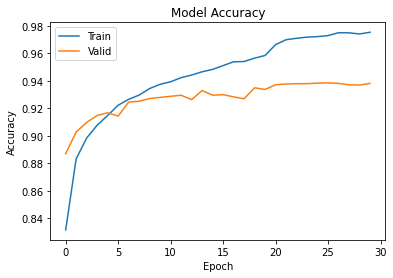

In [17]:
plotCurve(train_acc_list, valid_acc_list, "Accuracy")

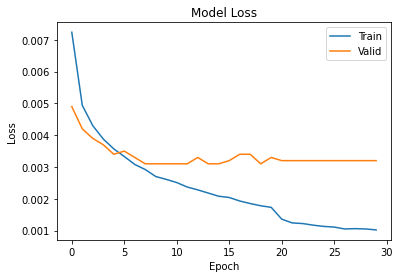

In [18]:
plotCurve(train_loss_list, valid_loss_list, "Loss")

In [19]:
accuracy = 0
total = 0
for image, label in testloader:
  image, label = image.to(device), label.to(device)
  output = model(image)
  _, pred = torch.max(output, dim=1)
  accuracy += torch.sum(pred == label)/len(pred)
  total += 1

accuracy /= total
print(f"TEST ACCURACY: {round(accuracy.item()*100,2)}%") 

TEST ACCURACY: 93.05%
